In [2]:
#
# ローソク足チャートを描く
#
%matplotlib inline
import datetime
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.finance as mf
from matplotlib.dates import date2num

In [3]:
import yaml
f = open('default.yaml', 'r+')
config = yaml.load(f)
f.close()
mongo_url = 'mongodb://' + config['mongo_user'] + ':' + config['mongo_pwd'] + '@' + config['mongo_host'] + ':' + config['mongo_port'] + '/' + config['mongo_db']

In [4]:
client = pymongo.MongoClient(mongo_url)
db = client.bitflyer
co = db.lightning_executions_FX_BTC_JPY_OHLC_300
#co = db.lightning_executions_FX_BTC_JPY_OHLC_3600
#co = db.lightning_executions_BTC_JPY_OHLC_86400
#co = db.lightning_executions_BCH_BTC_OHLC_300

In [5]:
date=[]
quote = []
volume_sell = []
volume_buy = []
volume_diff = []
volume_diff_total = []
_volume_diff_total = 0
close = []
_initial_close = 0


#open_dateがafter以降のデータ
#after = datetime.datetime(2017,6,11)
#for data in co.find({'open_date':{'$gte':after}}).sort('id',1):

#直近のデータ400件
count = 400
skip = 0
if (co.count() > count):
    skip = co.count() - count
else:
    count = co.count()
for data in co.find({}).skip(skip).sort('id',1):
    t = data['op_date'] + datetime.timedelta(hours=9)
    date.append(t)
    quote.append((date2num(t), data['op'], data['cl'], data['hi'], data['lo']))
    volume_sell.append(data['vol_sell'])
    volume_buy.append(data['vol_buy'])
    volume_diff.append(data['vol_buy']-data['vol_sell'])
    _volume_diff_total += (data['vol_buy']-data['vol_sell'])
    volume_diff_total.append(_volume_diff_total)
    if _initial_close == 0:
        _initial_close = data['op']
    close.append(data['cl'] - _initial_close)


In [6]:
# figure_width := ローソク足チャート全体の幅 (単位:日)
# candle_width := ローソクの幅 (単位:日)
delta = date[-1] - date[0]
figure_width = delta.total_seconds()/(60*60*24)
candle_width = 0.6 * figure_width / count;

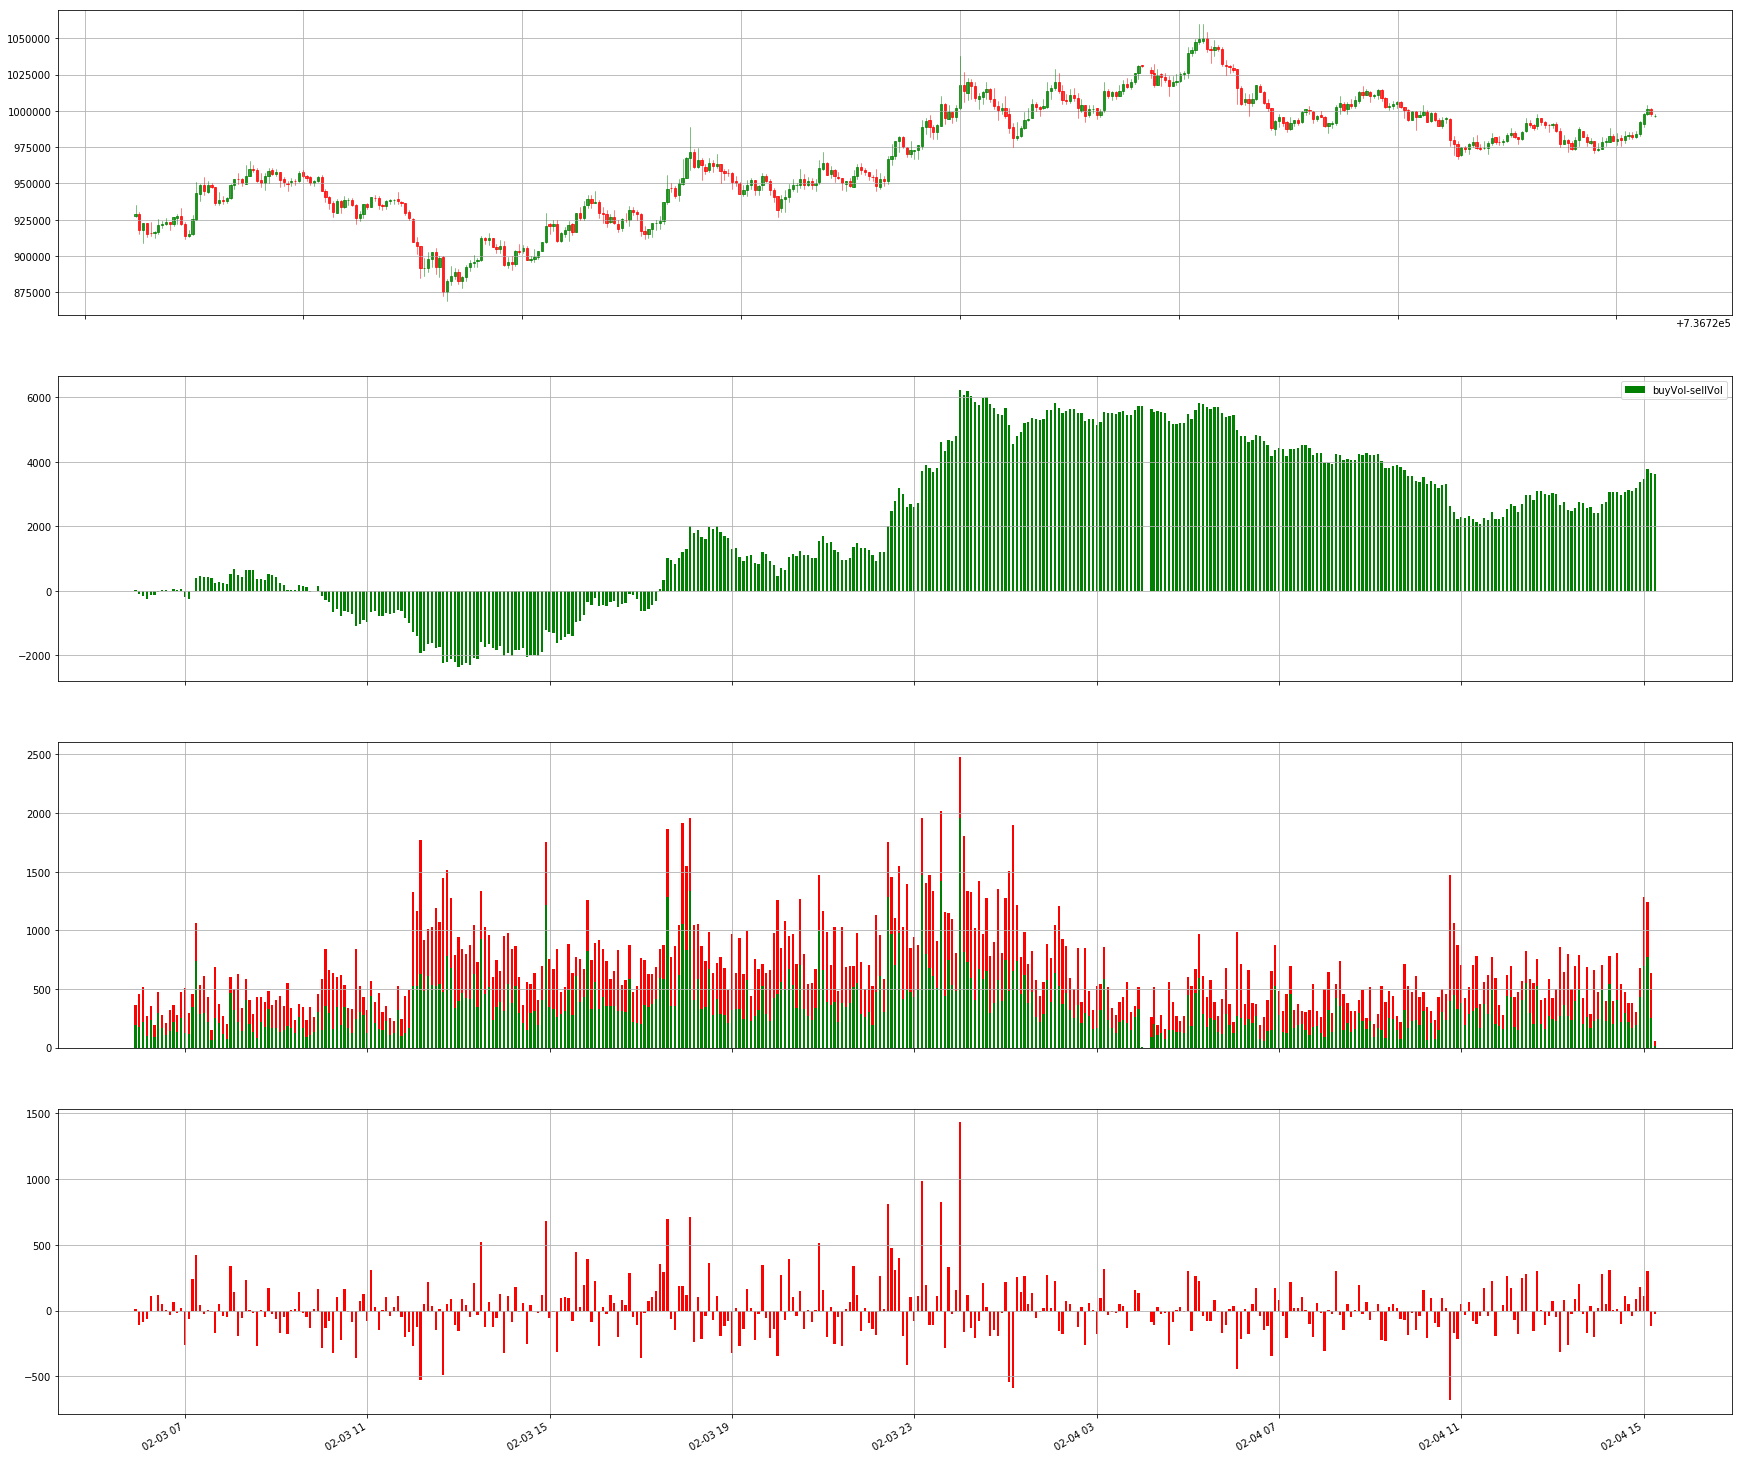

In [8]:
# ローソク足チャートを描く
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(411)
fig.subplots_adjust(top=0.85)
ax.grid()
#ax.set_xlim(date[0], date[-1])
mf.candlestick_ochl(ax, quote, width=candle_width, colorup='g', colordown='r', alpha=0.75)
fig.autofmt_xdate()

# 買い越しの量を描く
ax1 = fig.add_subplot(412)
fig.subplots_adjust(top=0.85)
ax1.grid()
ax1.bar(date, volume_diff_total, width=candle_width, color='g', label='buyVol-sellVol')
#ax1.set_xlim(date[0], date[-1])
ax1.legend()
fig.autofmt_xdate()

# 出来高の棒グラフを描く（赤＝売り、緑＝買い）
ax = fig.add_subplot(413)
ax.grid()
#ax.set_xlim(date[0], date[-1])
ax.bar(date, volume_buy, width=candle_width, color='g')
ax.bar(date, volume_sell, bottom=volume_buy, width=candle_width, color='r')
fig.autofmt_xdate()

# 出来高の棒グラフを描く（買い数量から売り数量を引いた）
ax = fig.add_subplot(414)
ax.grid()
#ax.set_xlim(date[0], date[-1])
ax.bar(date, volume_diff, width=candle_width, color='r')
fig.autofmt_xdate()

plt.show()
